<a href="https://colab.research.google.com/github/bhagirathtallapragada/Secure-AI-project--Implementing-adversarial-attacks-and-defenses-using-ART/blob/main/evasion_with_defenses_spai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1

     |████████████████████████████████| 1.1 MB 13.9 MB/s 
     |████████████████████████████████| 3.4 MB 51.6 MB/s 
     |████████████████████████████████| 25.3 MB 73 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
# mounting the drive to store the results

from google.colab import drive
drive.mount('/content/drive') #, force_remount = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import Model
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from keras.datasets import cifar10

from sklearn.metrics import classification_report
import pickle
import os

from art.estimators.classification import TensorFlowV2Classifier

## Import dataset

In [ ]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

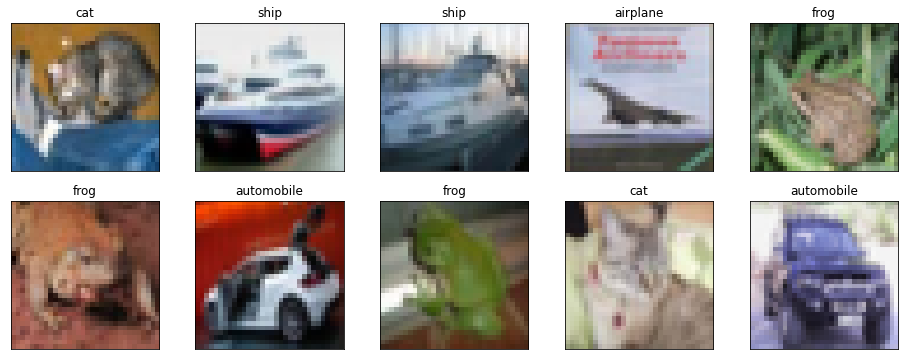

In [ ]:
# visualizing a few sample images

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize=(16,6))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    im = x_test[i, :]
    ax.set_title(class_names[y_test[i][0]])
    plt.imshow(im)
plt.show()

In [ ]:
# checking the format of data
print(type(x_train[0]))
print(x_train[0].shape)

# retaining the original format for the test data
x_test_retained=x_test.copy()

# Convert class vectors to binary class matrices.
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_train = tf.keras.utils.to_categorical(y_train, 10)

print(y_test.shape)
print(y_train.shape)

# Normalizing the data by converting to float and dividing by 255 (max value for r,g,b)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

# print(x_train[0])

<class 'numpy.ndarray'>
(32, 32, 3)
(10000, 10)
(50000, 10)


In [ ]:
# # using keras to load the given model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier.add(hub.KerasLayer(hub_url, signature='default'))
classifier.add(tf.keras.layers.Activation('softmax'))

classifier.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
print(classifier.summary())
# tf.keras.utils.plot_model(model, "my_first_model.png")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 10)                7796426   
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________
None


In [ ]:
# evaluating with a subset of training data. The expected accuracy is 1 since this is model is trained on Cifar10

tf.config.run_functions_eagerly(True)
x_train_trial=x_train[0:1000].copy()
y_train_trial=y_train[0:1000].copy()
classifier.evaluate(x_train_trial, y_train_trial)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


32/32 [==============================] - 11s 319ms/step - loss: 0.0017 - accuracy: 1.0000


[0.0016680299304425716, 1.0]

8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


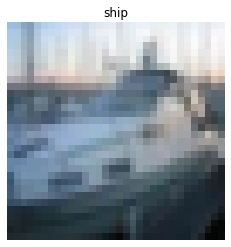

In [ ]:
# Visualizing a prediction using the non scaled and retained test data saved earlier

prediction = classifier.predict(x_test[:3])
ans = np.argmax(prediction[2])
print(ans)

plt.imshow(x_test_retained[2])
plt.axis( 'off' )
plt.title(class_names[ans])
plt.show( )

# Implementing Evasion Attacks

# White box attacks

Before implementing the attacks, we will take a set of 10 instances

from each class, totalling our candidate set to be of 100 samples

In [ ]:
# function to generate the needed samples for implementing attack

def candidate_data(x_test, y_test, n):
  cx_test=[]
  cy_test=[]
  
  for i in list(range(y_test.shape[1])):
    id = y_test[:,i]==1
    cx_test.append(x_test[id][:n].copy())
    cy_test.append(y_test[id][:n].copy())

  cx_test = np.concatenate(cx_test)
  cy_test = np.concatenate(cy_test)

  return cx_test, cy_test

(100, 32, 32, 3)
(100, 10)
class 8


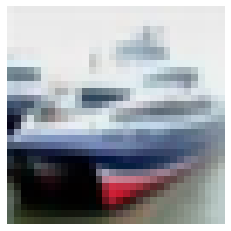

In [ ]:
# testing the sampling function

sample_test, sample_label=candidate_data(x_test, y_test, 10)

# print(adv_test[0])
print(sample_test.shape)
print(sample_label.shape)


print("class {}".format(np.argmax(sample_label[80])))
plt.imshow( sample_test[80])
plt.axis( 'off' )
plt.show( )

Check the model's performance on test data before implementing the attacks

In [ ]:
classifier.evaluate(x_test,y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 115s 368ms/step - loss: 0.2056 - accuracy: 0.9452


[0.20560911297798157, 0.9452000260353088]

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

In [ ]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

### Implementing a helper function to encapsulate each attack since it is a repetitive process across the attacks

In [ ]:
def implement_attack(classifier, attack, sample_test, test_labels, attack_name):
  # generate the adverserial examples
  x_test_adv = attack.generate(sample_test)
  performance_metrics=classifier.evaluate( x_test_adv, test_labels)
  predictions=classifier.predict(x_test_adv)
  report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1), output_dict=True)

  report=report['weighted avg']
  report.update({'Loss':performance_metrics[0]})
  report.update({'Accuracy':performance_metrics[1]})
  report.update({'Attack':attack_name})

  return report, x_test_adv, predictions


Also create a collective dictionary to hold the result metrics from each attack and store that in a csv file for future reference

In [ ]:
collective_res={}

## Implementing the Fast Gradient Sign Method attack

In [ ]:
# creating an fgsm attack
attack_fgsm = FastGradientMethod(estimator=artclassifier, targeted=False, eps_step=0.001, eps=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack_fgsm, sample_test=sample_test, test_labels=sample_label, attack_name='fgsm attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

4/4 [==============================] - 1s 196ms/step - loss: 3.9229 - accuracy: 0.4000


In [ ]:
# add the results to the collective dictionary
collective_res[report['Attack']]=report

In [ ]:
# check the dictionary
print(collective_res)

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}}


Actual test image
label: 0


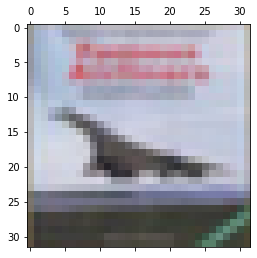

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


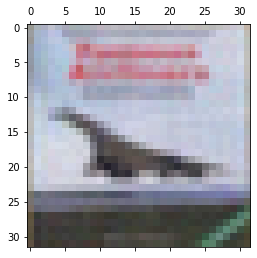

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

### Implementing defense mechanisms to counter this attack

In [ ]:
# checking the robustness of the model
from art.metrics import empirical_robustness

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the undefended model', 
      empirical_robustness( artclassifier, x_test, 'fgsm'))

robustness of the undefended model 0.11403236


#### Feature squeezing

In [ ]:
# Applying feature squeezing
from art.defences.preprocessor import FeatureSqueezing
fs_def = FeatureSqueezing(clip_values=(0,1), bit_depth=16, apply_fit = True, apply_predict = True)
x_def,y_def = fs_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 419s 267ms/step - loss: 0.0018 - accuracy: 1.0000


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 193ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
# checking the robustness of the defensively trained model
from art.metrics import empirical_robustness

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the defended model', 
      empirical_robustness( artclassifier, x_test_adv, 'fgsm'))

robustness of the defended model 0.110347666


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 195ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


#### Gaussian data augmentation

In [ ]:
# Applying Gaussian data augmentation (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import GaussianAugmentation
ga_def = GaussianAugmentation(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = ga_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

3125/3125 [==============================] - 1155s 369ms/step - loss: 3.1243 - accuracy: 0.5588


In [ ]:
# applying gaussian attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 276ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 274ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


In [ ]:
# checking the robustness of the defensively trained model
from art.metrics import empirical_robustness

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the defended model', 
      empirical_robustness( artclassifier, x_test_adv, 'fgsm'))

robustness of the defended model 0.110347666


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


#### Jpeg compression

In [ ]:
# Applying jpeg compression (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import JpegCompression
ga_def = JpegCompression(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = ga_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 428s 273ms/step - loss: 0.0018 - accuracy: 1.0000


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 208ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
# checking the robustness of the defensively trained model
from art.metrics import empirical_robustness

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the defended model', 
      empirical_robustness( artclassifier, x_test_adv, 'fgsm'))

robustness of the defended model 0.110347666


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 195ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
# save the results dictionary in a pickle file
f = open("/content/drive/MyDrive/spai/evadef_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

In [ ]:
# check to see if everything stored properly
file_to_read = open("/content/drive/MyDrive/spai/evadef_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
print(collective_res)

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}}


In [ ]:
# # Evaluate accuracy on adverserial test data and calculate average perturbation

# y_test_pred = np.argmax(model(x_test_adv), axis=1)
# accuracy_test_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
# perturbation = np.mean(np.abs((x_test_adv - x_test)))
# print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test_adv * 100))
# print('Average perturbation: {:4.2f}'.format(perturbation))

## Implementing the Carlini&Wagner Infinity-norm attack

In [ ]:
from art.attacks.evasion import CarliniLInfMethod

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_cw = CarliniLInfMethod(classifier=artclassifier, eps=0.3, max_iter=100, learning_rate=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack_cw, sample_test=sample_test, test_labels=sample_label, attack_name='Carlini&Wagner Infinity-norm attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

C&W L_inf:   0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 1s 198ms/step - loss: 2.1636 - accuracy: 0.3400


Actual test image
label: 0


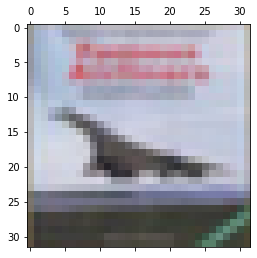

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


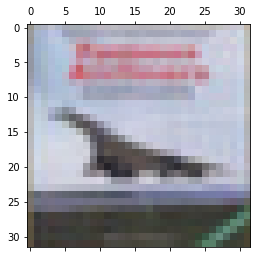

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}}


### Implementing defense mechanisms to counter Carlini & Wagner attack

#### Jpeg compression

In [ ]:
# Applying jpeg compression (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import JpegCompression
ga_def = JpegCompression(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = ga_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 421s 269ms/step - loss: 0.5699 - accuracy: 0.8346


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 203ms/step - loss: 2.1636 - accuracy: 0.3400
loss & accuracy on adversarial examples:  [2.163559913635254, 0.3400000035762787]


In [ ]:
# checking the robustness of the defensively trained model
from art.metrics import empirical_robustness

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the defended model', 
      empirical_robustness( artclassifier, x_test_adv, 'fgsm'))

robustness of the defended model 0.11038349


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 195ms/step - loss: 2.1636 - accuracy: 0.3400
loss & accuracy on adversarial examples:  [2.163559913635254, 0.3400000035762787]


#### Label smoothing

In [ ]:
# Applying label smoothing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import LabelSmoothing
lbsm_def = LabelSmoothing(max_value = 0.9, apply_fit = True, apply_predict = False)
x_def,y_def = lbsm_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 422s 270ms/step - loss: 1.2624 - accuracy: 1.0000


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 203ms/step - loss: 2.1636 - accuracy: 0.3400
loss & accuracy on adversarial examples:  [2.163559913635254, 0.3400000035762787]


In [ ]:
# # checking the robustness of the defensively trained model
# from art.metrics import empirical_robustness

# artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
#                                     clip_values=(0, 1), channels_first=False)

# # wrap the model an calculate empirical robustness
# # wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
# print( 'robustness of the defended model', 
#       empirical_robustness( artclassifier, x_test_adv, 'CarliniLInfMethod'))

#carlini method is currently not supported for this metric

In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 2.1636 - accuracy: 0.3400
loss & accuracy on adversarial examples:  [2.163559913635254, 0.3400000035762787]


#### Spatial Smoothing

In [ ]:
# Applying label smoothing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import SpatialSmoothing
spsmooth_def = SpatialSmoothing(window_size=3, clip_values=(0,1), apply_fit = True, apply_predict = False)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 423s 270ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 196ms/step - loss: 2.1636 - accuracy: 0.3400
loss & accuracy on adversarial examples:  [2.163559913635254, 0.3400000035762787]


In [ ]:
# # checking the robustness of the defensively trained model
# from art.metrics import empirical_robustness

# artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
#                                     clip_values=(0, 1), channels_first=False)

# # wrap the model an calculate empirical robustness
# # wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
# print( 'robustness of the defended model', 
#       empirical_robustness( artclassifier, x_test_adv, 'CarliniLInfMethod'))

#carlini method is currently not supported for this metric

In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 196ms/step - loss: 2.1636 - accuracy: 0.3400
loss & accuracy on adversarial examples:  [2.163559913635254, 0.3400000035762787]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()
 

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}}


## Implementing Projected Gradient Descent (PGD) attack

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=artclassifier, max_iter=10, eps=0.01, eps_step=0.001, targeted=False)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack_pgd, sample_test=sample_test, test_labels=sample_label, attack_name='Projected Gradient Descent attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

PGD - Batches: 0it [00:00, ?it/s]

4/4 [==============================] - 1s 197ms/step - loss: 9.8832 - accuracy: 0.1500


Actual test image
label: 0


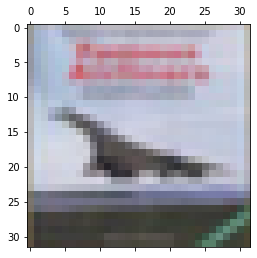

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


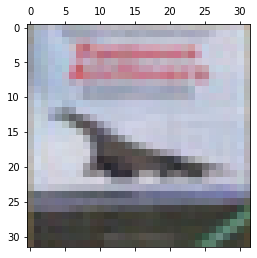

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}}


### Implementing defense mechanisms to counter this attack

#### Spatial Smoothing

In [ ]:
# Applying label smoothing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import SpatialSmoothing
spsmooth_def = SpatialSmoothing(window_size=3, clip_values=(0,1), apply_fit = True, apply_predict = False)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 424s 271ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 194ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# # checking the robustness of the defensively trained model
# from art.metrics import empirical_robustness

# artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
#                                     clip_values=(0, 1), channels_first=False)

# # wrap the model an calculate empirical robustness
# # wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
# print( 'robustness of the defended model', 
#       empirical_robustness( artclassifier, x_test_adv, 'CarliniLInfMethod'))

#carlini method is currently not supported for this metric

In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 200ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


#### Total variance Minimization

In [ ]:
# Applying total variance minimization (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import TotalVarMin
ttmin_def = TotalVarMin(clip_values=(0,1), apply_fit = True, apply_predict = False, lamb=0.5, prob=0.3)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 431s 269ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 193ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# # checking the robustness of the defensively trained model
# from art.metrics import empirical_robustness

# artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
#                                     clip_values=(0, 1), channels_first=False)

# # wrap the model an calculate empirical robustness
# # wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
# print( 'robustness of the defended model', 
#       empirical_robustness( artclassifier, x_test_adv, 'CarliniLInfMethod'))

#carlini method is currently not supported for this metric

In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 194ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


#### Feature squeezing

In [ ]:
# Applying feature squeezing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import FeatureSqueezing
fs_def = FeatureSqueezing(clip_values=(0,1), bit_depth=16, apply_fit = True, apply_predict = True)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 421s 269ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# # checking the robustness of the defensively trained model
# from art.metrics import empirical_robustness

# artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
#                                     clip_values=(0, 1), channels_first=False)

# # wrap the model an calculate empirical robustness
# # wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
# print( 'robustness of the defended model', 
#       empirical_robustness( artclassifier, x_test_adv, 'CarliniLInfMethod'))

#carlini method is currently not supported for this metric

In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}}


## Implementing Auto Projected Gradient Descent (AutoPGD) attack

In [ ]:
from art.attacks.evasion import AutoProjectedGradientDescent

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

## Some attacks, like Auto PGD, require linear activation in the last layer of classifier as they expect the classifier to generate logits values instead of softmax probabilities. Therefore, we define 'classifier2' and 'ARTclassifier2 wrapper' on the given model, defined with linear activations to implement these attacks.


In [ ]:
# re loading the model to be compatible for the APGD function call

hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model = hub.load(hub_url)

classifier2 = tf.keras.Sequential()
classifier2.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
# classifier.add(hub.KerasLayer(model.signatures['default']))
classifier2.add(hub.KerasLayer(hub_url, signature='default'))
classifier2.add(tf.keras.layers.Activation('linear'))

classifier2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=1e-4), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier2 = TensorFlowV2Classifier(model=classifier2, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

In [ ]:
attack_apgd = AutoProjectedGradientDescent(estimator=artclassifier2, max_iter=10, eps=0.08, eps_step=0.001, targeted=False)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier2, attack_apgd, sample_test=sample_test, test_labels=sample_label, attack_name='Auto Projected Gradient Descent attack eps:0.08')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/4 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/2 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 2s 272ms/step - loss: 0.9671 - accuracy: 0.3900


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual test image
label: 0


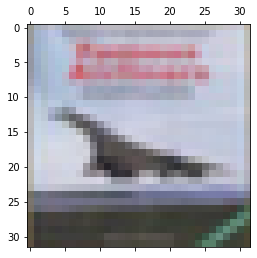

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 6


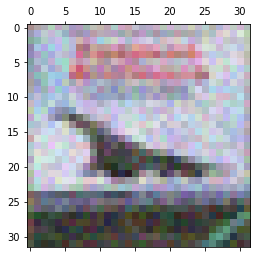

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

As we see in the observations for this attack. Epsilon value of 0.01 does not reduce the accuracy significantly (still at ~92%). Increasing it to 0.08 lowers the accuracy to ~0.41

In [ ]:
print(collective_res)

{'Auto Projected Gradient Descent attack eps:0.08': {'precision': 0.6815705128205128, 'recall': 0.42, 'f1-score': 0.4216909658636164, 'support': 100, 'Loss': 1.7729904651641846, 'Accuracy': 0.41999998688697815, 'Attack': 'Auto Projected Gradient Descent attack eps:0.08', 'perturbation': 0.047935158}}


### Implementing defenses to counter APGD attack

#### Class labels

In [ ]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 266ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### Gaussian noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 271ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Brendel & Bethge Attack (Using classifier 2 defined above with linear activation)

In [ ]:
from art.attacks.evasion import BrendelBethgeAttack

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_brendnbeth = BrendelBethgeAttack(estimator=artclassifier2, lr=0.05, steps=1, targeted=False)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier2, attack=attack_brendnbeth, sample_test=sample_test, test_labels=sample_label, attack_name='Brendel & Bethge attack eps:0.05')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 2s 267ms/step - loss: 0.1612 - accuracy: 0.0100


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual test image
label: 0


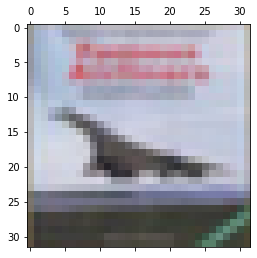

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 2


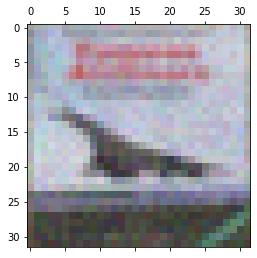

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Brendel & Bethge attack eps:0.05': {'precision': 0.001724137931034483, 'recall': 0.01, 'f1-score': 0.002941176470588235, 'support': 100, 'Loss': 0.16118106245994568, 'Accuracy': 0.009999999776482582, 'Attack': 'Brendel & Bethge attack eps:0.05', 'perturbation': 0.078267165}}


### Implementing defenses to counter Brendel and Bethge attack

#### High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### Reverse Sigmoid

In [ ]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rs_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### Rounded

In [ ]:
from art.defences.postprocessor import Rounded
rnd_def = Rounded(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rnd_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing NewtonFool Attack

In [ ]:
from art.attacks.evasion import NewtonFool

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_newt = NewtonFool(classifier=artclassifier, max_iter=10, batch_size=20,eta=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_newt, sample_test=sample_test, test_labels=sample_label, attack_name='Newton fool attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

NewtonFool:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 2s 271ms/step - loss: 2.5702 - accuracy: 0.0400


Actual test image
label: 0


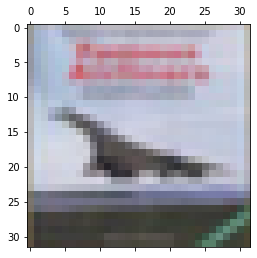

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


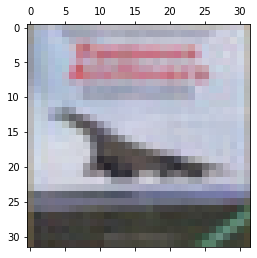

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'perturbation': 0.025158597}}


### Implementing defenses to counter Newton Fool attack

#### Rounded

In [ ]:
from art.defences.postprocessor import Rounded
rnd_def = Rounded(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rnd_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.5702 - accuracy: 0.0400
loss and accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


#### Gaussian data augmentation

In [ ]:
# Applying Gaussian data augmentation (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import GaussianAugmentation
ga_def = GaussianAugmentation(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = ga_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

3125/3125 [==============================] - 1155s 369ms/step - loss: 3.1243 - accuracy: 0.5588


In [ ]:
# applying gaussian attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 276ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 274ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


#### Jpeg compression

In [ ]:
# Applying jpeg compression (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import JpegCompression
jp_def = JpegCompression(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = jp_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 579s 370ms/step - loss: 0.5699 - accuracy: 0.8346


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 270ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 274ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Jacobian Saliency map attack

In [ ]:
from art.attacks.evasion import SaliencyMapMethod

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_jsm = SaliencyMapMethod(artclassifier, theta=0.1, gamma=1.0, batch_size=20)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_jsm, sample_test=sample_test, test_labels=sample_label, attack_name='Jacobian Saliency map attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

JSMA:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 1s 263ms/step - loss: 1.1288 - accuracy: 0.0200


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual test image
label: 0


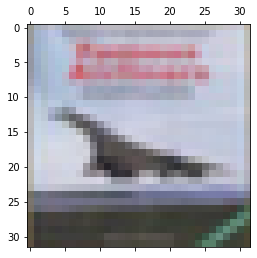

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 5


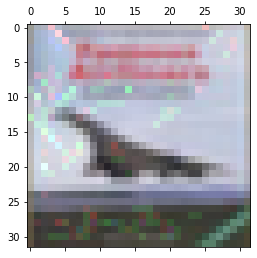

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Jacobian Saliency map attack': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100.0, 'Loss': 1.238205909729004, 'Accuracy': 0.0, 'Attack': 'Jacobian Saliency map attack', 'perturbation': 0.0023468523}}


### Implementing defenses to counter this attack

#### Jpeg compression

In [ ]:
# Applying jpeg compression (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import JpegCompression
jp_def = JpegCompression(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = jp_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 578s 369ms/step - loss: 0.5699 - accuracy: 0.8346


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 271ms/step - loss: 1.1288 - accuracy: 0.0200
loss & accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 267ms/step - loss: 1.1288 - accuracy: 0.0200
loss & accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


#### High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 270ms/step - loss: 1.1288 - accuracy: 0.0200
loss and accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


#### Reverse Sigmoid

In [ ]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rs_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 273ms/step - loss: 1.1288 - accuracy: 0.0200
loss and accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing DeepFool Attack (Using ARTclassifier2 and classifier 2)

In [ ]:
from art.attacks.evasion import DeepFool

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_deepf = DeepFool(classifier=artclassifier2, max_iter=10, batch_size=20,epsilon=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier2, attack=attack_deepf, sample_test=sample_test, test_labels=sample_label, attack_name='Deepfool attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

4/4 [==============================] - 2s 273ms/step - loss: 1.1921e-07 - accuracy: 0.0500


Actual test image
label: 0


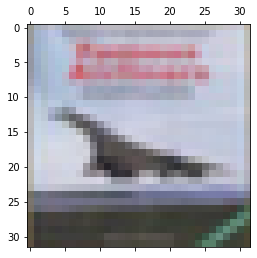

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


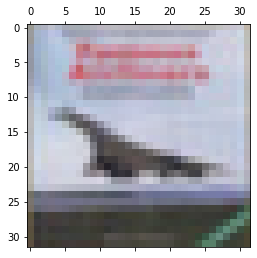

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Deepfool attack': {'precision': 0.0488095238095238, 'recall': 0.05, 'f1-score': 0.048224728487886385, 'support': 100, 'Loss': 1.1920930376163597e-07, 'Accuracy': 0.05000000074505806, 'Attack': 'Deepfool attack', 'perturbation': 0.0024195663}}


#### Class labels

In [ ]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 259ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


#### Gaussian noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 263ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


#### Rounded

In [ ]:
from art.defences.postprocessor import Rounded
rnd_def = Rounded(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rnd_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 263ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Virtual Adversarial Method attack

In [ ]:
from art.attacks.evasion import VirtualAdversarialMethod

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_VAM = VirtualAdversarialMethod(classifier=artclassifier, max_iter=10, batch_size=20,eps=0.05)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_VAM, sample_test=sample_test, test_labels=sample_label, attack_name='Virtual Adverserial Attack eps:0.05')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

VAT:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/art/attacks/evasion/virtual_adversarial.py:156: RuntimeWarning: invalid value encountered in subtract
  var_d_new[:, current_index] = (kl_div2 - kl_div1) / self.finite_diff


Actual test image
label: 0


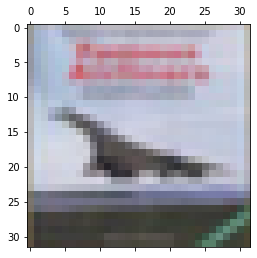

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 0


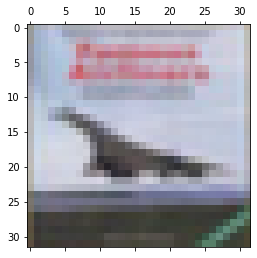

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Virtual Adverserial Attack': {'precision': 0.9301515151515152, 'recall': 0.92, 'f1-score': 0.921540973646237, 'support': 100, 'Loss': 0.3494209051132202, 'Accuracy': 0.9200000166893005, 'Attack': 'Virtual Adverserial Attack', 'perturbation': 0.00012545292}}


### Implementing defenses for this attack

#### Class labels

In [ ]:
from art.defences.postprocessor import Rounded
rnd_def = Rounded(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rnd_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### Reverse Sigmoid

In [ ]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rs_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

#### Gaussian noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 271ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Feature Adversaries attack

In [ ]:
from art.attacks.evasion import FeatureAdversariesTensorFlowV2

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_fadv = FeatureAdversariesTensorFlowV2(estimator=artclassifier2, max_iter=10, batch_size=20,delta=0.01, step_size=1)

The attack implementation requires function calls to be made differently for this attack therefore defining a modified implementation function below called implement_attack2

In [ ]:
def implement_attack2(classifier, attack, sample_test, test_labels, attack_name):
  # generate the adverserial examples
  x_test_adv = attack.generate(sample_test, test_labels)
  performance_metrics=classifier.evaluate( x_test_adv, test_labels)
  predictions=classifier.predict(x_test_adv)
  report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1), output_dict=True)

  report=report['weighted avg']
  report.update({'Loss':performance_metrics[0]})
  report.update({'Accuracy':performance_metrics[1]})
  report.update({'Attack':attack_name})

  return report, x_test_adv, predictions

In [ ]:
report, x_test_adv, predictions = implement_attack2(classifier2, attack=attack_fadv, sample_test=sample_test, test_labels=sample_label, attack_name='Features adversariesTFV2 Attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

# sample_label_adv = sample_label.copy()
# sample_test_evasion = attack.generate( sample_test.copy() ,sample_label_adv.copy())


ValueError: ignored

Actual test image
label: 0


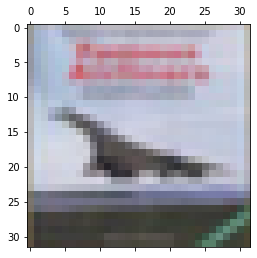

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


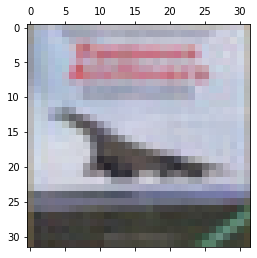

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Shadow attack

In [ ]:
from art.attacks.evasion import ShadowAttack

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_shad = ShadowAttack(estimator=artclassifier, batch_size=20, learning_rate=0.01, targeted=False)

In [ ]:
# report, x_test_adv, predictions = implement_attack(classifier, attack=attack_shad, sample_test=sample_test[0], test_labels=sample_label[0], attack_name='Shadow Attack')
# perturbation = np.mean(np.abs((x_test_adv - sample_test)))
# report['perturbation']=perturbation

x_test_adv = [attack_shad.generate( i.reshape((1,32,32,3))) for i in sample_test.copy()]

performance_metrics = classifier.evaluate(x_test_adv, sample_label)
predictions=classifier.predict(x_test_adv)
report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1), output_dict=True)

report=report['weighted avg']
report.update({'Loss':performance_metrics[0]})
report.update({'Accuracy':performance_metrics[1]})
report.update({'Attack':'shadow attack'})

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Actual test image
label: 0


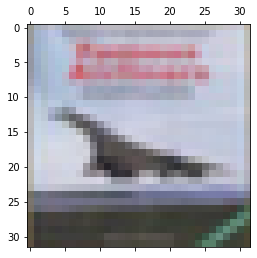

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


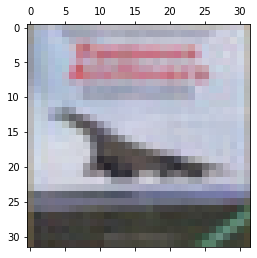

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'perturbation': 0.025158597}}


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Wasserstein attack

In [ ]:
from art.attacks.evasion import Wasserstein

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_wass = Wasserstein(classifier=artclassifier, max_iter=10, batch_size=20,eps=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_wass, sample_test=sample_test, test_labels=sample_label, attack_name='Wasserstein Attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

VAT:   0%|          | 0/5 [00:00<?, ?it/s]

Actual test image
label: 0


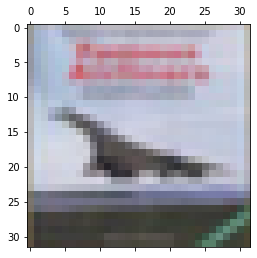

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


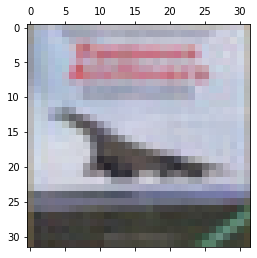

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

### Implementing defenses against this attack

#### Class labels

In [ ]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 266ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### Gaussian noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 271ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Targeted Universal Adversarial Perturbations attack

In [ ]:
from art.attacks.evasion import TargetedUniversalPerturbation

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_wass = TargetedUniversalPerturbation(classifier=artclassifier, max_iter=10, batch_size=20,eps=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_wass, sample_test=sample_test, test_labels=sample_label, attack_name='TargetedUniversalPerturbation attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

VAT:   0%|          | 0/5 [00:00<?, ?it/s]

Actual test image
label: 0


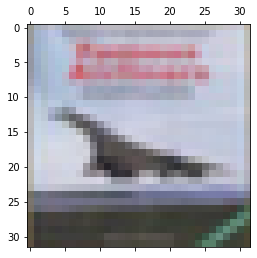

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


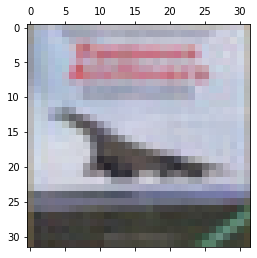

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'perturbation': 0.025158597}}


### Implementing defenses against this attack

#### Spatial Smoothing

In [ ]:
# Applying label smoothing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import SpatialSmoothing
spsmooth_def = SpatialSmoothing(window_size=3, clip_values=(0,1), apply_fit = True, apply_predict = False)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 424s 271ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 194ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 200ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


#### Total variance Minimization

In [ ]:
# Applying total variance minimization (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import TotalVarMin
ttmin_def = TotalVarMin(clip_values=(0,1), apply_fit = True, apply_predict = False, lamb=0.5, prob=0.3)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 431s 269ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 193ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 194ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


#### Feature squeezing

In [ ]:
# Applying feature squeezing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import FeatureSqueezing
fs_def = FeatureSqueezing(clip_values=(0,1), bit_depth=16, apply_fit = True, apply_predict = True)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 421s 269ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing High Confidence Low Uncertainty (HCLU) Attack

In [ ]:
from art.attacks.evasion import HighConfidenceLowUncertainty

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_wass = HighConfidenceLowUncertainty(classifier=artclassifier, max_iter=10, batch_size=20,eps=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_wass, sample_test=sample_test, test_labels=sample_label, attack_name='HighConfidenceLowUncertainty attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

VAT:   0%|          | 0/5 [00:00<?, ?it/s]

Actual test image
label: 0


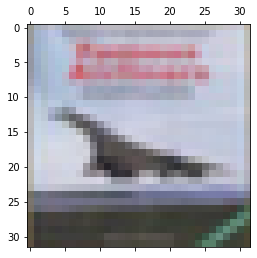

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


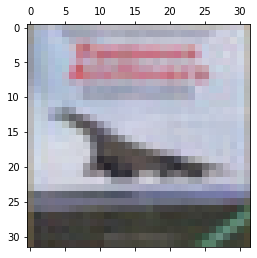

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

### Implementing defenses against this attack

#### Jpeg compression

In [ ]:
# Applying jpeg compression (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import JpegCompression
jp_def = JpegCompression(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = jp_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 578s 369ms/step - loss: 0.5699 - accuracy: 0.8346


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 271ms/step - loss: 1.1288 - accuracy: 0.0200
loss & accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 267ms/step - loss: 1.1288 - accuracy: 0.0200
loss & accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


#### High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 270ms/step - loss: 1.1288 - accuracy: 0.0200
loss and accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


#### Reverse Sigmoid

In [ ]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rs_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 273ms/step - loss: 1.1288 - accuracy: 0.0200
loss and accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Iterative Frame Saliency

In [ ]:
from art.attacks.evasion import FrameSaliencyAttack

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_wass = FrameSaliencyAttack(classifier=artclassifier, max_iter=10, batch_size=20,eps=0.01)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_wass, sample_test=sample_test, test_labels=sample_label, attack_name='FrameSaliency attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

VAT:   0%|          | 0/5 [00:00<?, ?it/s]

Actual test image
label: 0


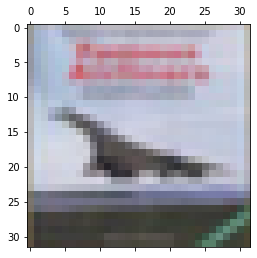

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


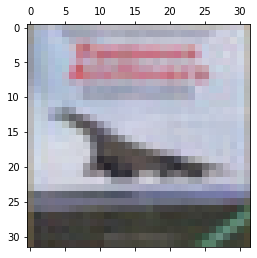

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'perturbation': 0.025158597}}


### Implementing defenses for this attack

#### Feature squeezing

In [ ]:
# Applying feature squeezing
from art.defences.preprocessor import FeatureSqueezing
fs_def = FeatureSqueezing(clip_values=(0,1), bit_depth=16, apply_fit = True, apply_predict = True)
x_def,y_def = fs_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 419s 267ms/step - loss: 0.0018 - accuracy: 1.0000


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 193ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
# checking the robustness of the defensively trained model
from art.metrics import empirical_robustness

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the defended model', 
      empirical_robustness( artclassifier, x_test_adv, 'fgsm'))

robustness of the defended model 0.110347666


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 195ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


#### Gaussian data augmentation

In [ ]:
# Applying Gaussian data augmentation (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import GaussianAugmentation
ga_def = GaussianAugmentation(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = ga_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

3125/3125 [==============================] - 1155s 369ms/step - loss: 3.1243 - accuracy: 0.5588


In [ ]:
# applying gaussian attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 276ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 274ms/step - loss: 2.5702 - accuracy: 0.0400
loss & accuracy on adversarial examples:  [2.5702431201934814, 0.03999999910593033]


In [ ]:
# checking the robustness of the defensively trained model
from art.metrics import empirical_robustness

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the defended model', 
      empirical_robustness( artclassifier, x_test_adv, 'fgsm'))

robustness of the defended model 0.110347666


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


#### Jpeg compression

In [ ]:
# Applying jpeg compression (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import JpegCompression
ga_def = JpegCompression(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = ga_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 428s 273ms/step - loss: 0.0018 - accuracy: 1.0000


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 208ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
# checking the robustness of the defensively trained model
from art.metrics import empirical_robustness

artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False)

# wrap the model an calculate empirical robustness
# wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the defended model', 
      empirical_robustness( artclassifier, x_test_adv, 'fgsm'))

robustness of the defended model 0.110347666


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 195ms/step - loss: 3.9229 - accuracy: 0.4000
loss & accuracy on adversarial examples:  [3.9228835105895996, 0.4000000059604645]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Black box attacks

## Implementing HopSkipJump attack

In [ ]:
from art.attacks.evasion import HopSkipJump

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_hpskp = HopSkipJump(classifier=artclassifier, batch_size=20, max_iter=10 ,max_eval=10000, init_eval=10, targeted=False)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_hpskp, sample_test=sample_test, test_labels=sample_label, attack_name='Hop skip jump attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 1s 249ms/step - loss: 2.3571 - accuracy: 0.0800


Actual test image
label: 0


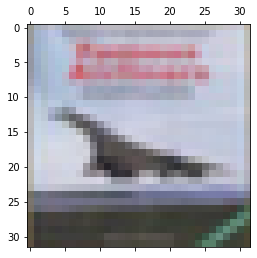

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 8


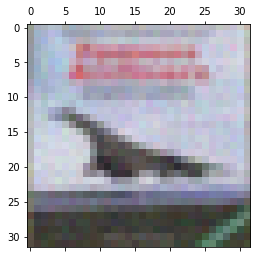

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Hop skip jump attack': {'precision': 0.0837427278603749, 'recall': 0.08, 'f1-score': 0.06721360480951274, 'support': 100, 'Loss': 2.3571038246154785, 'Accuracy': 0.07999999821186066, 'Attack': 'Hop skip jump attack', 'perturbation': 0.019591752}}


### Implementing defenses against this attack

#### Class labels

In [ ]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 266ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### Gaussian noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 271ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


#### High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 268ms/step - loss: 2.2091 - accuracy: 0.3900
loss and accuracy on adversarial examples:  [2.209076404571533, 0.38999998569488525]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Pixel attack

In [ ]:
from art.attacks.evasion import PixelAttack

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_pixat = PixelAttack(artclassifier, es=1, max_iter=10, targeted=False)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_pixat, sample_test=sample_test, test_labels=sample_label, attack_name='Pixel attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 1s 253ms/step - loss: 1.8246 - accuracy: 0.0500


Actual test image
label: 0


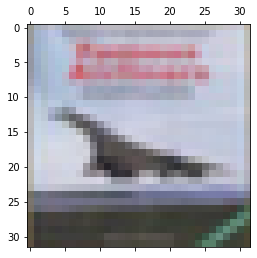

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


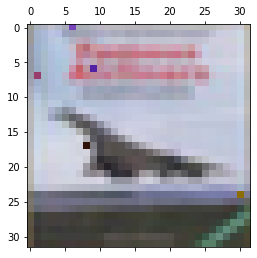

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Pixel attack': {'precision': 0.05014652014652014, 'recall': 0.05, 'f1-score': 0.04717625058438523, 'support': 100, 'Loss': 1.8246055841445923, 'Accuracy': 0.05000000074505806, 'Attack': 'Pixel attack', 'perturbation': 0.0037594596}}


### Implementing defenses against this attack

#### Class labels

In [ ]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 259ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


#### Gaussian noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 263ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


#### Rounded

In [ ]:
from art.defences.postprocessor import Rounded
rnd_def = Rounded(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rnd_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 263ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Spatial Transformation attack

In [ ]:
from art.attacks.evasion import SpatialTransformation

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_spat = SpatialTransformation(artclassifier, num_translations=2, max_rotation=10, max_translation=15)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_spat, sample_test=sample_test, test_labels=sample_label, attack_name='Spatial transformation attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

Spatial transformation:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 1s 242ms/step - loss: 0.7546 - accuracy: 0.7800


Actual test image
label: 0


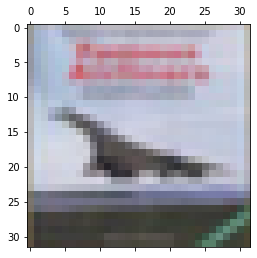

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 8


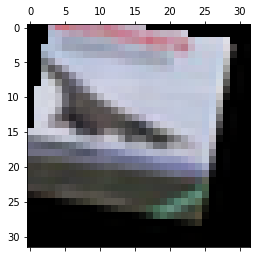

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Spatial transformation attack': {'precision': 0.8159541847041847, 'recall': 0.78, 'f1-score': 0.7807003746167832, 'support': 100, 'Loss': 0.7545679211616516, 'Accuracy': 0.7799999713897705, 'Attack': 'Spatial transformation attack', 'perturbation': 0.27634802}}


### Implementing defenses against this attack

#### Spatial Smoothing

In [ ]:
# Applying label smoothing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import SpatialSmoothing
spsmooth_def = SpatialSmoothing(window_size=3, clip_values=(0,1), apply_fit = True, apply_predict = False)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 424s 271ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 194ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 200ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


#### Total variance Minimization

In [ ]:
# Applying total variance minimization (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import TotalVarMin
ttmin_def = TotalVarMin(clip_values=(0,1), apply_fit = True, apply_predict = False, lamb=0.5, prob=0.3)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 431s 269ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 193ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 194ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


#### Feature squeezing

In [ ]:
# Applying feature squeezing (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import FeatureSqueezing
fs_def = FeatureSqueezing(clip_values=(0,1), bit_depth=16, apply_fit = True, apply_predict = True)
x_def,y_def = spsmooth_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 421s 269ms/step - loss: 0.3276 - accuracy: 0.9020


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 197ms/step - loss: 9.8832 - accuracy: 0.1500
loss & accuracy on adversarial examples:  [9.883171081542969, 0.15000000596046448]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Threshold attack

In [ ]:
from art.attacks.evasion import ThresholdAttack

In [ ]:
!python -m pip install cma

     |████████████████████████████████| 269 kB 30.8 MB/s 


In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_thresh = ThresholdAttack(artclassifier, max_iter=10, targeted=False, th=None)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_thresh, sample_test=sample_test, test_labels=sample_label, attack_name='Threshold attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 1s 242ms/step - loss: 1.2039 - accuracy: 0.0500


Actual test image
label: 0


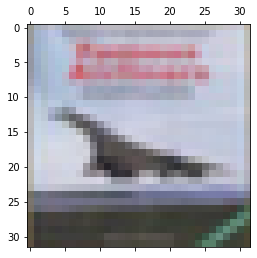

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 9


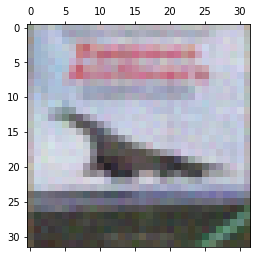

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'Threshold attack': {'precision': 0.07088235294117647, 'recall': 0.05, 'f1-score': 0.05306974506974507, 'support': 100, 'Loss': 1.2039027214050293, 'Accuracy': 0.05000000074505806, 'Attack': 'Threshold attack', 'perturbation': 0.016782235}}


### Implementing defenses against this attack

#### Jpeg compression

In [ ]:
# Applying jpeg compression (make sure to reset the training data and classifier before applying this defence)

from art.defences.preprocessor import JpegCompression
jp_def = JpegCompression(clip_values=(0,1), apply_fit = True, apply_predict = True)
x_def,y_def = jp_def.__call__(x=x_train,y=y_train)

classifier.fit(x_def,y_def)

1563/1563 [==============================] - 578s 369ms/step - loss: 0.5699 - accuracy: 0.8346


In [ ]:
# applying fgsm attack samples on the defensively robust model
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 271ms/step - loss: 1.1288 - accuracy: 0.0200
loss & accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


In [ ]:
# checking the performance of adverserial examples on the model trained with defensively robust samples
perf =  classifier.evaluate(x_test_adv, sample_label)
print( 'loss & accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 267ms/step - loss: 1.1288 - accuracy: 0.0200
loss & accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


#### High confidence

In [ ]:
from art.defences.postprocessor import HighConfidence
hc_def = HighConfidence(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=hc_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 2s 270ms/step - loss: 1.1288 - accuracy: 0.0200
loss and accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


#### Reverse Sigmoid

In [ ]:
from art.defences.postprocessor import ReverseSigmoid
rs_def = ReverseSigmoid(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rs_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 273ms/step - loss: 1.1288 - accuracy: 0.0200
loss and accuracy on adversarial examples:  [1.1288288831710815, 0.019999999552965164]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur

## Implementing Zeroth order optimization attack 

In [ ]:
from art.attacks.evasion import ZooAttack

In [ ]:
sample_test, sample_label=candidate_data(x_test, y_test, 10)

In [ ]:
attack_zoo = ZooAttack(artclassifier, confidence=1,binary_search_steps=1, initial_const=0.001, targeted=False, learning_rate=0.05, max_iter=10, 
                abort_early=True, use_resize=True,use_importance=True, nb_parallel=128, batch_size=1, variable_h=0.0001)

In [ ]:
report, x_test_adv, predictions = implement_attack(classifier, attack=attack_zoo, sample_test=sample_test, test_labels=sample_label, attack_name='ZOO attack conf: 1 lr:0.05')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

ZOO:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 1s 239ms/step - loss: 0.3580 - accuracy: 0.9100


Actual test image
label: 0


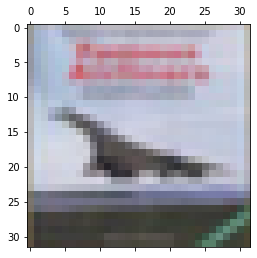

In [ ]:
print("Actual test image")
print("label: {}".format(np.argmax(sample_label[0])))
plt.matshow(sample_test[0])
plt.show()

Adverserial test image
predicted label: 0


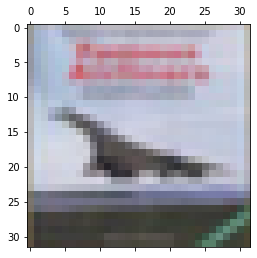

In [ ]:
print("Adverserial test image")
print("predicted label: {}".format(np.argmax(predictions[0])))
plt.matshow(x_test_adv[0])
plt.show()

In [ ]:
# add the results to the collective dictionary
collective_res={}
collective_res[report['Attack']]=report

In [ ]:
print(collective_res)

{'ZOO attack conf: 1 lr:0.05': {'precision': 0.9125252525252524, 'recall': 0.91, 'f1-score': 0.9098746867167921, 'support': 100, 'Loss': 0.3580020070075989, 'Accuracy': 0.9100000262260437, 'Attack': 'ZOO attack conf: 1 lr:0.05', 'perturbation': 7.11099e-05}}


### Implementing defenses against this attack

#### Class labels

In [ ]:
from art.defences.postprocessor import ClassLabels
classlabel_def = ClassLabels(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=classlabel_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 259ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


#### Gaussian noise

In [ ]:
from art.defences.postprocessor import GaussianNoise
gaussn_def = GaussianNoise(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=gaussn_def)

# evaluating the attack samples
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 263ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


#### Rounded

In [ ]:
from art.defences.postprocessor import Rounded
rnd_def = Rounded(apply_fit = False, apply_predict = True)

# Applying the post processing defence to the classifier being defended
artclassifier = TensorFlowV2Classifier(model=classifier, nb_classes=10, input_shape=(32, 32, 3), loss_object=classifier.loss, 
                                    clip_values=(0, 1), channels_first=False, postprocessing_defences=rnd_def)

# evaluating the attack samples on the defended model
perf =  artclassifier._model.evaluate( x_test_adv, sample_label )
print( 'loss and accuracy on adversarial examples: ', perf )

4/4 [==============================] - 1s 263ms/step - loss: 0.8783 - accuracy: 0.0500
loss and accuracy on adversarial examples:  [0.8782680034637451, 0.05000000074505806]


In [ ]:
# Append the results of this attack to the pickle file storing the collective results

file_to_read = open("/content/drive/MyDrive/spai/evasion_results.pickle", "rb")

collective_res = pickle.load(file_to_read)
file_to_read.close()
collective_res[report['Attack']]=report
print(collective_res)

# pickle the updated dictionary again
f = open("/content/drive/MyDrive/spai/evasion_results.pickle", "wb")
pickle.dump(collective_res, f)
f.close()

{'fgsm attack': {'precision': 0.4121328671328671, 'recall': 0.4, 'f1-score': 0.4013180177310612, 'support': 100, 'Loss': 3.9228830337524414, 'Accuracy': 0.4000000059604645, 'Attack': 'fgsm attack', 'perturbation': 0.009887331}, 'Carlini&Wagner Infinity-norm attack': {'precision': 0.3261736874236874, 'recall': 0.34, 'f1-score': 0.32546210335334036, 'support': 100, 'Loss': 2.163559913635254, 'Accuracy': 0.3400000035762787, 'Attack': 'Carlini&Wagner Infinity-norm attack', 'perturbation': 0.012366227}, 'Projected Gradient Descent attack': {'precision': 0.143262987012987, 'recall': 0.15, 'f1-score': 0.1446283979178716, 'support': 100, 'Loss': 9.883766174316406, 'Accuracy': 0.15000000596046448, 'Attack': 'Projected Gradient Descent attack', 'perturbation': 0.0064626606}, 'Newton fool attack': {'precision': 0.049166666666666664, 'recall': 0.04, 'f1-score': 0.043611111111111114, 'support': 100, 'Loss': 2.5702431201934814, 'Accuracy': 0.03999999910593033, 'Attack': 'Newton fool attack', 'pertur